# Math 425 Fall 2025 Project 1  
**Due:** 5PM on Fri October 10  

## Project Directions
- Include a report on every group member’s contribution.  
- Submit the group’s well-commented code used for the project with instructions on how to compile and run.  
- Make a 15 to 20 minute video presentation of your results.  

The project consists of 3 problems.

You are given part of the **Wisconsin Diagnostic Breast Cancer (WDBC) dataset**. For each patient, you are given a vector $\mathbf{a}$ giving features computed from digitized images of a fine needle aspirate (FNA) of a breast mass. The features describe characteristics of the cell nuclei present in the image. The goal is to decide whether the cells are malignant or benign.  

### Feature Computation
Ten real-valued quantities are computed for each cell nucleus:
- **radius** (mean of distances from center to points on the perimeter)  
- **texture** (standard deviation of gray-scale values)  
- **perimeter**  
- **area**  
- **smoothness** (local variation in radius lengths)  
- **compactness** $\;=\; \dfrac{\text{perimeter}^2}{\text{area}} - 1.0$  
- **concavity** (severity of concave portions of the contour)  
- **concave points** (number of concave portions of the contour)  
- **symmetry**  
- **fractal dimension** (“coastline approximation” - 1)  

The **mean**, **standard error (stderr)**, and a measure of the **largest (worst)** values were computed for each feature.  
Thus, each specimen is represented by a vector $\mathbf{a}$ with **30 entries**.  

The domain $D$ consists of thirty strings identifying these features, e.g.  
- `radius (mean)`  
- `radius (stderr)`  
- `radius (worst)`  
- `area (mean)`  

### Provided Files
- `train.txt`: data for 300 patients  
- `train_values.txt`: indicator for malignant specimen (+1) or benign specimen (−1)  
- `validate.txt`: data for 260 patients  
- `validate_values.txt`: indicator for malignant specimen (+1) or benign specimen (−1) 

## Problem 1
**(a)** Apply $k$-means clustering with $k=2$ to the training data.  
Then use the validation data to assess clustering accuracy. You will need a scheme to determine whether a patient in the validation set has a malignant or benign tumor based on clustering.  

In [1]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
import numpy as np
import warnings
warnings.filterwarnings("ignore", message="KMeans is known to have a memory leak")


url = "https://raw.githubusercontent.com/ddangman/Math425_Project1/refs/heads/main/Files/Wisconsin_Breast_Cancer_Data/train.txt"
matrixA = pd.read_csv(url, sep=",", header=None)

url = "https://raw.githubusercontent.com/ddangman/Math425_Project1/refs/heads/main/Files/Wisconsin_Breast_Cancer_Data/validate.txt"
validateA = pd.read_csv(url, sep=",", header=None)

url = "https://raw.githubusercontent.com/ddangman/Math425_Project1/refs/heads/main/Files/Wisconsin_Breast_Cancer_Data/train_values.txt"
vector_b = pd.read_csv(url, sep=",", header=None)

url = "https://raw.githubusercontent.com/ddangman/Math425_Project1/refs/heads/main/Files/Wisconsin_Breast_Cancer_Data/validate_values.txt"
validate_b = pd.read_csv(url, sep=",", header=None)

# Train KMeans on training data
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
kmeans.fit(matrixA)

# Predict cluster assignments for validation set
val_clusters = kmeans.predict(validateA)

# Map clusters to labels
# KMeans cluster labels (0 or 1) don’t automatically correspond to malignant (+1) or benign (-1).
# We need to assign clusters based on which cluster has more of each label in training data.
train_clusters = kmeans.predict(matrixA)
cluster_to_label = {}

for cluster in np.unique(train_clusters):
    # Find majority label in this cluster
    labels_in_cluster = vector_b.iloc[train_clusters == cluster, 0]
    majority_label = labels_in_cluster.value_counts().idxmax()
    cluster_to_label[cluster] = majority_label

# Convert validation clusters to predicted labels
val_pred_labels = [cluster_to_label[c] for c in val_clusters]

# Calculate accuracy
acc = accuracy_score(validate_b, val_pred_labels)

print("Validation Accuracy:", acc)

Validation Accuracy: 0.926923076923077


**(b)** Embed the data in dimensions $d \in \{5, 10, 20\}$ using **Gaussian matrix embedding**, then rerun $k$-means.  
- What is the clustering accuracy for each $d$?  
- What is the computational time averaged over 500 independent runs? 

In [2]:
import time
from sklearn.random_projection import GaussianRandomProjection

# Dimensions to embed
dims = [5, 10, 20]
results = {}

# Track total runtime
overall_start = time.time()

for d in dims:
    accuracies = []
    times = []
    
    for _ in range(500):  # repeat 500 runs
        start = time.time()
        
        # Gaussian embedding
        projector = GaussianRandomProjection(n_components=d)
        A_embedded = projector.fit_transform(matrixA)
        val_embedded = projector.transform(validateA)

        # Train KMeans
        kmeans = KMeans(n_clusters=2, random_state=None, n_init=10)
        kmeans.fit(A_embedded)

        # Map clusters to labels (majority vote on training data)
        train_clusters = kmeans.predict(A_embedded)
        cluster_to_label = {}
        for cluster in np.unique(train_clusters):
            labels_in_cluster = vector_b.iloc[train_clusters == cluster, 0]
            majority_label = labels_in_cluster.value_counts().idxmax()
            cluster_to_label[cluster] = majority_label

        # Predict validation labels
        val_clusters = kmeans.predict(val_embedded)
        val_pred_labels = [cluster_to_label[c] for c in val_clusters]

        # Accuracy
        acc = accuracy_score(validate_b, val_pred_labels)
        accuracies.append(acc)

        # Runtime
        times.append(time.time() - start)
    
    # Save averages
    results[d] = {
        "avg_accuracy": np.mean(accuracies),
        "avg_time": np.mean(times)
    }

# Compute total runtime
total_runtime = time.time() - overall_start

# Display results
for d in results:
    print(f"Dimension {d}: Accuracy = {results[d]['avg_accuracy']:.4f}, "
          f"Avg Time = {results[d]['avg_time']:.6f} seconds")

print(f"\nTotal runtime for all experiments: {total_runtime:.2f} seconds")

Dimension 5: Accuracy = 0.9270, Avg Time = 0.386350 seconds
Dimension 10: Accuracy = 0.9277, Avg Time = 0.391366 seconds
Dimension 20: Accuracy = 0.9279, Avg Time = 0.392607 seconds

Total runtime for all experiments: 585.16 seconds


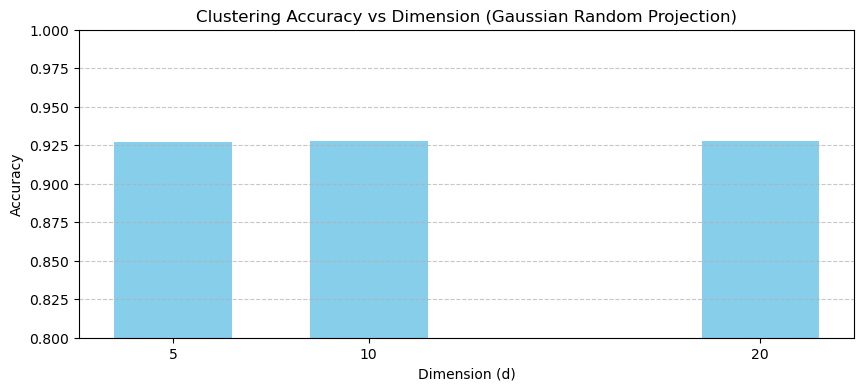

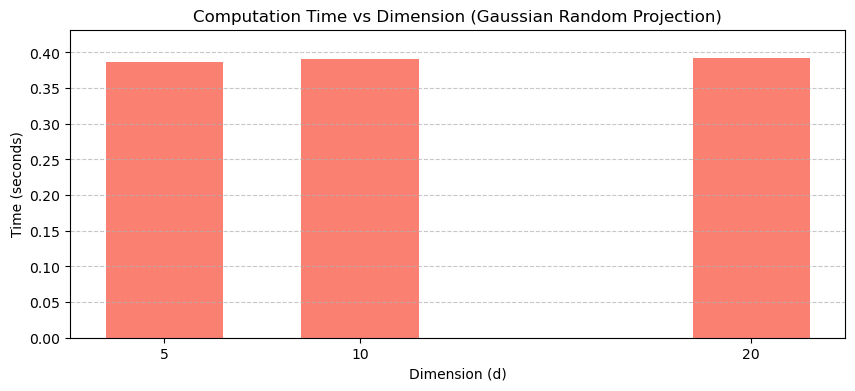

In [3]:
import matplotlib.pyplot as plt

dims_list = list(results.keys())
acc_list = [results[d]["avg_accuracy"] for d in dims_list]
time_list = [results[d]["avg_time"] for d in dims_list]

# Bar chart: Accuracy
plt.figure(figsize=(10,4))
plt.bar(dims_list, acc_list, color="skyblue", width=3)
plt.title("Clustering Accuracy vs Dimension (Gaussian Random Projection)")
plt.xlabel("Dimension (d)")
plt.ylabel("Accuracy")
plt.xticks(dims_list)
plt.ylim(.8,1)  # accuracy range
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

# Bar chart: Runtime
plt.figure(figsize=(10,4))
plt.bar(dims_list, time_list, color="salmon", width=3)
plt.title("Computation Time vs Dimension (Gaussian Random Projection)")
plt.xlabel("Dimension (d)")
plt.ylabel("Time (seconds)")
plt.xticks(dims_list)
plt.ylim(0, max(time_list) * 1.1)  # add 10% margin
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


**(c)** Repeat part (b) but use **sparse random projection** instead of Gaussian embedding.  

In [4]:
from sklearn.random_projection import SparseRandomProjection

dims = [5, 10, 20]
results_sparse = {}

# Track total runtime
overall_start = time.time()

for d in dims:
    accuracies = []
    times = []

    for _ in range(500):  # repeat 500 runs
        start = time.time()

        # Sparse random projection
        projector = SparseRandomProjection(n_components=d)
        A_embedded = projector.fit_transform(matrixA)
        val_embedded = projector.transform(validateA)

        # KMeans clustering
        kmeans = KMeans(n_clusters=2, random_state=None, n_init=10)
        kmeans.fit(A_embedded)

        # Map clusters -> labels
        train_clusters = kmeans.predict(A_embedded)
        cluster_to_label = {}
        for cluster in np.unique(train_clusters):
            labels_in_cluster = vector_b.iloc[train_clusters == cluster, 0]
            majority_label = labels_in_cluster.value_counts().idxmax()
            cluster_to_label[cluster] = majority_label

        # Predict validation labels
        val_clusters = kmeans.predict(val_embedded)
        val_pred_labels = [cluster_to_label[c] for c in val_clusters]

        # Accuracy & runtime
        acc = accuracy_score(validate_b, val_pred_labels)
        accuracies.append(acc)
        times.append(time.time() - start)

    results_sparse[d] = {
        "avg_accuracy": float(np.mean(accuracies)),
        "avg_time": float(np.mean(times))
    }

# Compute total runtime
total_runtime = time.time() - overall_start

# Print summary
for d in results_sparse:
    print(f"[Sparse RP] d={d}: Accuracy={results_sparse[d]['avg_accuracy']:.4f}, "
          f"Avg Time={results_sparse[d]['avg_time']:.6f} sec")

print(f"\nTotal runtime for all experiments: {total_runtime:.2f} seconds")

[Sparse RP] d=5: Accuracy=0.9246, Avg Time=0.424253 sec
[Sparse RP] d=10: Accuracy=0.9266, Avg Time=0.424654 sec
[Sparse RP] d=20: Accuracy=0.9274, Avg Time=0.425052 sec

Total runtime for all experiments: 636.98 seconds


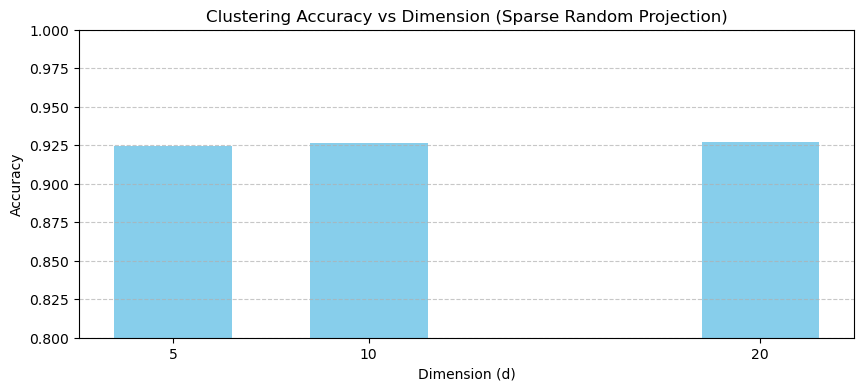

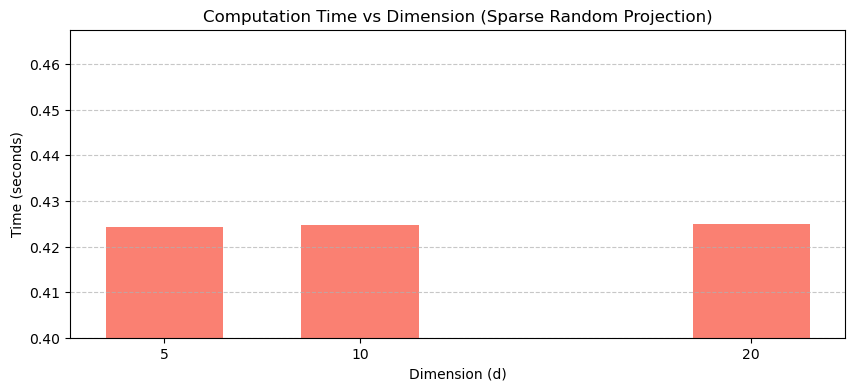

In [5]:
# Bar chart: Accuracy
dims_list = list(results_sparse.keys())
acc_list = [results_sparse[d]["avg_accuracy"] for d in dims_list]
time_list = [results_sparse[d]["avg_time"] for d in dims_list]

plt.figure(figsize=(10,4))
plt.bar(dims_list, acc_list, color="skyblue", width=3)
plt.title("Clustering Accuracy vs Dimension (Sparse Random Projection)")
plt.xlabel("Dimension (d)")
plt.ylabel("Accuracy")
plt.xticks(dims_list)
plt.ylim(0.8,1)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

# Bar chart: Runtime
plt.figure(figsize=(10,4))
plt.bar(dims_list, time_list, color="salmon", width=3)
plt.title("Computation Time vs Dimension (Sparse Random Projection)")
plt.xlabel("Dimension (d)")
plt.ylabel("Time (seconds)")
plt.xticks(dims_list)
plt.ylim(0.4, max(time_list) * 1.1)  # add 10% margin
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

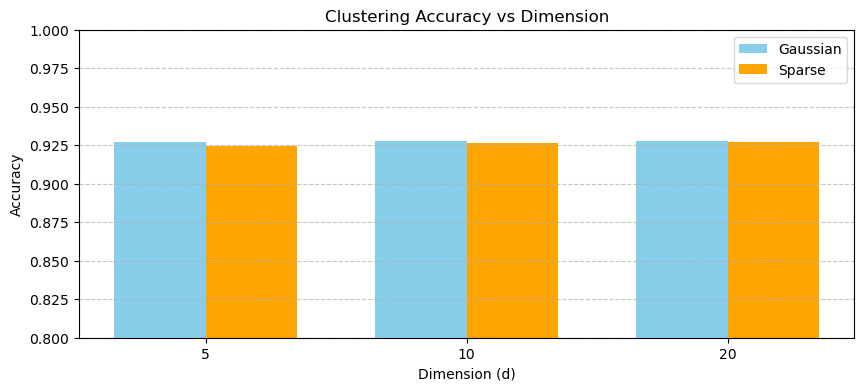

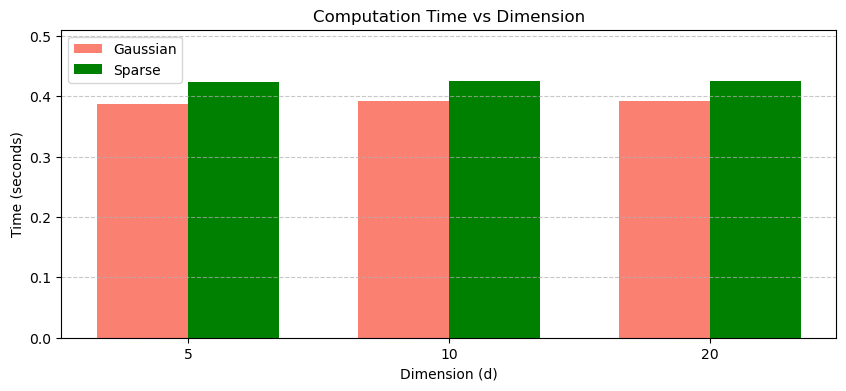

In [6]:
dims_list = list(results.keys())

# Accuracy lists
acc_gaussian = [results[d]["avg_accuracy"] for d in dims_list]
acc_sparse   = [results_sparse[d]["avg_accuracy"] for d in dims_list]

# Runtime lists
time_gaussian = [results[d]["avg_time"] for d in dims_list]
time_sparse   = [results_sparse[d]["avg_time"] for d in dims_list]

x = np.arange(len(dims_list))  # x positions for groups
width = 0.35  # width of bars

# Accuracy comparison
plt.figure(figsize=(10,4))
plt.bar(x - width/2, acc_gaussian, width, label="Gaussian", color="skyblue")
plt.bar(x + width/2, acc_sparse,   width, label="Sparse",   color="orange")
plt.xticks(x, dims_list)
plt.title("Clustering Accuracy vs Dimension")
plt.xlabel("Dimension (d)")
plt.ylabel("Accuracy")
plt.ylim(0.8, 1.0)  # adjust as needed
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.legend()
plt.show()

# Runtime comparison
plt.figure(figsize=(10,4))
plt.bar(x - width/2, time_gaussian, width, label="Gaussian", color="salmon")
plt.bar(x + width/2, time_sparse,   width, label="Sparse",   color="green")
plt.xticks(x, dims_list)
plt.title("Computation Time vs Dimension")
plt.xlabel("Dimension (d)")
plt.ylabel("Time (seconds)")
plt.ylim(0, max(max(time_gaussian), max(time_sparse)) * 1.2)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.legend()
plt.show()


## Problem 2
- Read the data in `train.txt` into a matrix $A$ (rows = patients, columns = 30 features).  

In [7]:
url = "https://raw.githubusercontent.com/ddangman/Math425_Project1/refs/heads/main/Files/Wisconsin_Breast_Cancer_Data/train.txt"

matrixA = pd.read_csv(url, sep=",", header=None)
print(matrixA.shape)
matrixA.head()

(300, 30)


,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


- Read the data in `train_values.txt` into a vector $b$ where  

In [8]:
url = "https://raw.githubusercontent.com/ddangman/Math425_Project1/refs/heads/main/Files/Wisconsin_Breast_Cancer_Data/train_values.txt"

vector_b = pd.read_csv(url, sep=",", header=None)
print(vector_b.shape)
vector_b.head()

(300, 1)


,0
0,1
1,1
2,1
3,1
4,1


  $$
  b_i = \begin{cases} 
  +1 & \text{if malignant} \\ 
  -1 & \text{if benign} 
  \end{cases}
  $$

**(a)** Use the **QR algorithm** to find the least-squares linear model for the data. 

**(b)** Apply the linear model to `validate.txt` and predict malignancy. Define a classifier:

$$
C(y) = \begin{cases} 
+1 & \text{if } y \geq 0 \\ 
-1 & \text{otherwise}
\end{cases}
$$

In [9]:
url = "https://raw.githubusercontent.com/ddangman/Math425_Project1/refs/heads/main/Files/Wisconsin_Breast_Cancer_Data/validate.txt"

validateA = pd.read_csv(url, sep=",", header=None)
print(validateA.shape)
validateA.head()

(260, 30)


,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,19.53,18.90,129.50,1217.0,0.11500,0.16420,0.21970,0.10620,0.1792,0.06552,...,25.93,26.24,171.10,2053.0,0.1495,0.4116,0.61210,0.19800,0.2968,0.09929
1,12.46,19.89,80.43,471.3,0.08451,0.10140,0.06830,0.03099,0.1781,0.06249,...,13.46,23.07,88.13,551.3,0.1050,0.2158,0.19040,0.07625,0.2685,0.07764
2,20.09,23.86,134.70,1247.0,0.10800,0.18380,0.22830,0.12800,0.2249,0.07469,...,23.68,29.43,158.80,1696.0,0.1347,0.3391,0.49320,0.19230,0.3294,0.09469
3,10.49,18.61,66.86,334.3,0.10680,0.06678,0.02297,0.01780,0.1482,0.06600,...,11.06,24.54,70.76,375.4,0.1413,0.1044,0.08423,0.06528,0.2213,0.07842
4,11.46,18.16,73.59,403.1,0.08853,0.07694,0.03344,0.01502,0.1411,0.06243,...,12.68,21.61,82.69,489.8,0.1144,0.1789,0.12260,0.05509,0.2208,0.07638


In [10]:
url = "https://raw.githubusercontent.com/ddangman/Math425_Project1/refs/heads/main/Files/Wisconsin_Breast_Cancer_Data/validate_values.txt"

validate_b = pd.read_csv(url, sep=",", header=None)
print(validate_b.shape)
validate_b.head()

(260, 1)


,0
0,1
1,-1
2,1
3,-1
4,-1


**(c)** What is the percentage of incorrectly classified samples? Compare with the success rate on the training data.  

**(d)** Embed the data in $d \in \{5, 10, 20\}$ using **Gaussian matrix embedding** and repeat (a), (b), and (c). Report average computational time over 500 runs.  

**(e)** Repeat part (d) but use **sparse random projection** instead.  

## Problem 3
Apply $k$-means to the **class music data** `songList.xlsx` and use **Class Roster** to group the class into **8 distinct music clusters**.


In [11]:
url = "https://github.com/ddangman/Math425_Project1/raw/main/Files/MATH425_songList.xlsx"
song_df = pd.read_excel(url)

print(song_df.head())


                      Song        Artist    1    2    3    4    5    6    7  \
0               Take On Me          A-Ha  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1            Thunderstruck         Ac/Dc  0.0  0.0  0.0  0.0  3.0  0.0  0.0   
2                    Hello         Adele  2.0  0.0  0.0  0.0  3.0  1.0  0.0   
3      Rolling In The Deep         Adele  0.0  0.0  0.0  0.0  4.0  1.0  0.0   
4  Scars To Your Beautiful  Alessia Cara  0.0  0.0  0.0  0.0  3.0  0.0  0.0   

     8  ...   23   24   25   26   27   28   29   30   31   32  
0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
1  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
3  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
4  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[5 rows x 34 columns]
